In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import pickle, datetime

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input, TimeDistributed,Convolution2D,Activation
from keras.layers.convolutional import ZeroPadding2D
from keras.optimizers import RMSprop, SGD
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Import the backend
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import os

Using TensorFlow backend.


# Caricamento immagini ed elaborazione
# Cartella X ---> training set
# Cartella Y ---> validation set

In [2]:
train_fruit_images = []
train_fruit_labels = [] 
for directory_path in glob.glob("X/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_fruit_images.append(img)
        train_fruit_labels.append(fruit_label)
train_fruit_images = np.array(train_fruit_images)
train_fruit_labels = np.array(train_fruit_labels)

In [3]:
label_to_id = {v:i for i,v in enumerate(np.unique(train_fruit_labels))}
id_to_label = {v: k for k, v in label_to_id.items()}
train_label_ids = np.array([label_to_id[x] for x in train_fruit_labels])



In [4]:
train_fruit_images.shape, train_label_ids.shape, train_fruit_labels.shape

((1900, 227, 227, 3), (1900,), (1900,))

In [5]:
# test
test_fruit_images = []
test_fruit_labels = [] 
for directory_path in glob.glob("Y/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        test_fruit_images.append(img)
        test_fruit_labels.append(fruit_label)
test_fruit_images = np.array(test_fruit_images)
test_fruit_labels = np.array(test_fruit_labels)

In [6]:
test_label_ids = np.array([label_to_id[x] for x in test_fruit_labels])

In [7]:
test_fruit_images.shape, test_label_ids.shape

((639, 227, 227, 3), (639,))

In [8]:
x_train, y_train, x_test, y_test, N_CATEGORY =train_fruit_images,train_fruit_labels,test_fruit_images,test_fruit_labels,len(label_to_id)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, N_CATEGORY)

(1900, 227, 227, 3) (1900,) (639, 227, 227, 3) (639,) 4


<h3> Visualizzazione tipi di frutta del dataset </h3>

In [9]:
id_to_label

{0: 'Apricot', 1: 'Avocado', 2: 'Avocado ripe', 3: 'Banana'}

### AlexNet

In [10]:
def get_alexnet(input_shape,nb_classes): 
    model = Sequential()

    # Layer 1
    model.add(Convolution2D(96, 11, 11, input_shape = input_shape, border_mode='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    model.add(Convolution2D(128, 5, 5, border_mode='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))

    # Layer 3
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(384, 3, 3, border_mode='same'))
    model.add(Activation('relu'))

    # Layer 4
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(192, 3, 3, border_mode='same'))
    model.add(Activation('relu'))

    # Layer 5
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 6
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, init='glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 7
    model.add(Dense(4096, init='glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # Layer 8
    model.add(Dense(nb_classes, init='glorot_normal'))
    model.add(Activation('tanh'))
    return model

In [11]:
alexnet = get_alexnet((227,227,3),N_CATEGORY)
alexnet.summary()

c:\users\benci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (11, 11), input_shape=(227, 227,..., padding="same")`
  """


Instructions for updating:
Colocations handled automatically by placer.


c:\users\benci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (5, 5), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
c:\users\benci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(384, (3, 3), padding="same")`
  app.launch_new_instance()
c:\users\benci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
c:\users\benci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
c:\users\benci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Dense` call to

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 227, 227, 96)      34944     
_________________________________________________________________
activation_1 (Activation)    (None, 227, 227, 96)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 113, 113, 96)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 113, 113, 128)     307328    
_________________________________________________________________
activation_2 (Activation)    (None, 113, 113, 128)     0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 58, 58, 128)      

c:\users\benci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:37: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4096, kernel_initializer="glorot_normal")`
c:\users\benci\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="glorot_normal")`


In [12]:
#Normalization of the images and one-hot encoding of the labels
alexnet.compile(loss='categorical_crossentropy', optimizer=RMSprop(),metrics=['accuracy'])
X_normalized = np.array(x_train / 255.0 - 0.5 )
X_normalized_test = np.array(x_test / 255.0 - 0.5 )

label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(y_train)
y_one_hot_test = label_binarizer.fit_transform(y_test)

In [13]:
#Training the AlexNet model with the normalized image data and labels
alexnet.fit(X_normalized, y_one_hot, batch_size=5, epochs=2,verbose=1, validation_data=[X_normalized_test,y_one_hot_test])

Instructions for updating:
Use tf.cast instead.
Train on 1900 samples, validate on 639 samples
Epoch 1/2
1900/1900 [==============================] - 6439s 3s/step - loss: 1.3931 - accuracy: 0.2589 - val_loss: 1.3863 - val_accuracy: 0.2567
Epoch 2/2
1900/1900 [==============================] - 5942s 3s/step - loss: 1.3863 - accuracy: 0.2589 - val_loss: 1.3863 - val_accuracy: 0.2567


#### Result of the Alexnet
Accurancy: 25.67%.




In [14]:
#Save the AlexNet
alexnet.save('alexnetfruit.h5') 

### Feature Extraction by CNN

In [15]:
#Pick the first Fully-Connected layer as the features which will be of dimension (1 x 4096)
layer_name = 'dense_1'
FC_layer_model = Model(inputs=alexnet.input,
                                 outputs=alexnet.get_layer(layer_name).output)

In [17]:
#Find the Features for n number of train images and we will get n x 4096
#This means we will get 4096 features for each images.
i=0
features=np.zeros(shape=(x_train.shape[0],4096))
for directory_path in glob.glob("X/*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features[i]=FC_output
        i+=1


KeyboardInterrupt: 

In [18]:
#Save the features of the train images
np.save('features', features)

In [33]:

feature_col=[]
for i in range(4096):
    feature_col.append("f_"+str(i))
    i+=1
    

In [34]:
#Create DataFrame with features and coloumn name
train_features=pd.DataFrame(data=features,columns=feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(train_label_ids))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_label_ids.shape)
train_class

Training Features Shape: (1900, 4096)
Training Labels Shape: (1900,)


[0, 1, 2, 3]

# -------------------- ipotesi da valutare -----------------------

### Alternativa che dovrebbe migliorare l'accurancy : Random Forest as Classifier

In [35]:
# utilizzo delle feature con il random forest
rf = RandomForestClassifier(n_estimators = 20, random_state = 42,max_features=4)

rf.fit(train_features, train_label_ids)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Testing  Algorithm

#### Feature Extraction by CNN (AlexNet)

In [36]:
#Find the Features from Alexnet's FC layer for n number of test images and we will get n x 4096
i=0
features_test=np.zeros(shape=(y_test.shape[0],4096))
for directory_path in glob.glob("Y/*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        features_test[i]=FC_output
        i+=1


In [37]:

test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', test_label_ids.shape)


Test Features Shape: (639, 4096)
Test Labels Shape: (639,)


#### Classification by Random Forest

In [38]:
#Feed the features of the test images to Random Forest Classifier to predict its class
predictions = rf.predict(test_features)

### Checking the Accuracy of the Novel Model

In [39]:
accuracy=accuracy_score(predictions , test_label_ids)
print('Accuracy:', accuracy*100, '%.')

Accuracy: 25.665101721439747 %.


### Comparision of CNN vs CNN+RF

Al momento non vediamo miglioramenti che dovrebbero esserci aumentando il set di dati

# ---------------------------------------------------------------------

In [72]:
good_match = 0
wrong_match = 0
for directory_path in glob.glob("testing/*"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        
        path = img_path[8:]
        path = path.split("\\")
        tipo = path[0]
        img_path=img_path
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (227, 227))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        img = np.expand_dims(img, axis=0)
        FC_output = FC_layer_model.predict(img)
        image_features=pd.DataFrame(data=FC_output,columns=feature_col)
        predictions = rf.predict(image_features)
        predizione = id_to_label[predictions[0]]
        if tipo == predizione :
            good_match = good_match +  1
        else :
            wrong_match = wrong_match + 1
        
print("Match esatti :",good_match,"\nMatch errati:",wrong_match)
        

Match esatti : 10 
Match errati: 4


Predictions: Banana


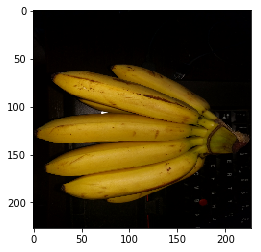

In [42]:

img_path="Bananas(lady_finger)1.jpg"
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (227, 227))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
FC_output = FC_layer_model.predict(img)
image_features=pd.DataFrame(data=FC_output,columns=feature_col)
predictions = rf.predict(image_features)
print("Predictions:",id_to_label[predictions[0]])